# XGBOOST Model 

### Motivations and Methodology
We decided to use XGBoost as a key part of our modeling pipeline due to its reputation for delivering high predictive performance, especially on structured/tabular data like ours. XGBoost (Extreme Gradient Boosting) is an ensemble method that builds a series of decision trees in sequence, where each new tree attempts to correct the errors made by the previous ones. This approach allows it to effectively capture complex, non-linear relationships in the data.

Unlike Random Forest, which averages predictions from many uncorrelated trees, XGBoost uses **gradient boosting**, making it better at minimizing residual errors and improving overall accuracy. XGBoost also supports **regularization**, helping reduce overfitting—an important consideration given the long time series and potential noise in weather data.

We used the same lag feature engineering pipeline as in the Random Forest model, and tuned hyperparameters such as:
- `n_estimators` (number of boosting rounds),
- `max_depth` (tree depth),
- `learning_rate` (shrinkage step size),
- `subsample`, and
- `colsample_bytree` (to reduce overfitting).

We evaluated XGBoost across the three forecasting horizons (1h, 6h, 24h) using the same train-validation-test split and evaluation metrics (MAE, MSE, R²), allowing fair comparison with Random Forest and baseline Decision Trees.


# Prepping the data (similarly to Random Forest)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load raw weather data
data = pd.read_csv("../data/weather_data.csv")

# Create datetime index
start_date = pd.to_datetime("2010-01-01 00:00:00")
data["date_time"] = pd.date_range(start=start_date, periods=len(data), freq='h')

# Copy for transformation
df_final = data.copy()

# Scale selected continuous features
scaler = StandardScaler()
features_to_scale = ["temperature", "wind_speed", "mean_sea_level_pressure", "surface_thermal_radiation"]
df_final[features_to_scale] = scaler.fit_transform(df_final[features_to_scale])

# Normalize solar radiation from W/m² to kW/m² for consistency
df_final["surface_solar_radiation"] = df_final["surface_solar_radiation"] / 1000

# Add temporal features directly to df_final
df_final["hour"] = df_final["date_time"].dt.hour
df_final["dayofweek"] = df_final["date_time"].dt.dayofweek
df_final["is_daylight"] = (df_final["surface_solar_radiation"] > 0).astype(int)
df_final["low_p_dummy"] = (df_final["mean_sea_level_pressure"] < 98000).astype(int)

# Add rolling averages directly
for col in ["temperature", "wind_speed", "surface_solar_radiation"]:
    df_final[f"{col}_roll3"] = df_final[col].rolling(window=3).mean()

# Drop NaNs
df_final.dropna(inplace=True)

# Then update features list (after all new columns are added)
target = "relative_humidity"
available_features = [col for col in df_final.columns if col not in ["date_time", target]]

# 1. Sort data chronologically - important for time series
df_final = df_final.sort_values("date_time").reset_index(drop=True)

# 2. Split into 80% trainval and 20% test (no shuffling)
split_index = int(len(df_final) * 0.8)
df_trainval = df_final.iloc[:split_index].copy().reset_index(drop=True) #slices data based on index position
df_test = df_final.iloc[split_index:].copy().reset_index(drop=True)

# 3. Within training set, split 80% train and 20% validation (also in order)
train_split_index = int(len(df_trainval) * 0.8)
df_train= df_trainval.iloc[:train_split_index].copy().reset_index(drop=True)
df_val = df_trainval.iloc[train_split_index:].copy().reset_index(drop=True)


In [4]:
### Checking the dataset
df_train.head()
df_val.head()

,temperature,wind_speed,mean_sea_level_pressure,surface_solar_radiation,surface_thermal_radiation,total_cloud_cover,relative_humidity,date_time,hour,dayofweek,is_daylight,low_p_dummy,temperature_roll3,wind_speed_roll3,surface_solar_radiation_roll3
0,1.077611,-0.375494,0.566281,0.39389,0.609284,0.39,0.69,2017-04-22 05:00:00,5,5,1,1,1.016624,-0.229156,0.384820
1,0.892857,-0.746216,0.566983,0.21844,1.420383,0.25,0.73,2017-04-22 06:00:00,6,5,1,1,0.988522,-0.437281,0.319913
2,0.839046,-1.170595,0.608513,0.12952,1.033813,0.36,0.76,2017-04-22 07:00:00,7,5,1,1,0.936504,-0.764101,0.247283
3,0.629180,-1.063281,0.637913,0.01669,0.552802,0.65,0.82,2017-04-22 08:00:00,8,5,1,1,0.787028,-0.993364,0.121550
4,0.622005,-1.170595,0.696941,0.00000,1.084222,0.69,0.83,2017-04-22 09:00:00,9,5,0,1,0.696744,-1.134823,0.048737


# Checking the optimal N_lags for XGBoost

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# === SAMPLE SUBSET FOR FASTER RUNTIME ===
forecast_horizon = 1  # Start with forecast horizon of 1
lag_N_candidates = [1, 3, 6, 12, 24, 48, 72]
target = "relative_humidity"
train_subset = df_train.iloc[-40000:].copy()  # Smaller for speed
val_subset = df_val.copy()
available_features = [col for col in df_final.columns if col not in ["date_time", target]]

# === FUNCTION TO GENERATE LAGGED FEATURES ===
def create_lag_features(df, N, horizon, feature_cols):
    lagged_frames = []
    for i in range(N):
        lag = df[feature_cols].shift(i + horizon)
        lag.columns = [f"{col}_lag{i + horizon}" for col in feature_cols]
        lagged_frames.append(lag)
    full_df = pd.concat([df] + lagged_frames, axis=1).dropna().reset_index(drop=True)
    return full_df

# === LAG TUNING LOOP ===
results = []

for N in lag_N_candidates:
    print(f"🔍 Evaluating lag_N = {N}")
    
    train_lagged = create_lag_features(train_subset, N, forecast_horizon, available_features)
    val_lagged = create_lag_features(val_subset, N, forecast_horizon, available_features)

    X_train = train_lagged[[col for col in train_lagged.columns if "lag" in col]]
    y_train = train_lagged[target]
    X_val = val_lagged[[col for col in val_lagged.columns if "lag" in col]]
    y_val = val_lagged[target]

    model = XGBRegressor(n_estimators=50, max_depth=4, learning_rate=0.1, random_state=42, verbosity=0)
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    mse = mean_squared_error(y_val, preds)
    r2 = r2_score(y_val, preds)

    results.append({
        "Lag_N": N,
        "MAE": mae,
        "MSE": mse,
        "R2": r2
    })

# === VIEW RESULTS ===
results_df = pd.DataFrame(results)
print("\n📊 Lag Tuning Results (XGBoost):")
print(results_df.sort_values(by="MSE"))


🔍 Evaluating lag_N = 1
🔍 Evaluating lag_N = 3
🔍 Evaluating lag_N = 6
🔍 Evaluating lag_N = 12
🔍 Evaluating lag_N = 24
🔍 Evaluating lag_N = 48
🔍 Evaluating lag_N = 72

📊 Lag Tuning Results (XGBoost):
   Lag_N       MAE       MSE        R2
4     24  0.055266  0.005054  0.808388
5     48  0.055272  0.005061  0.807969
6     72  0.055306  0.005071  0.807610
3     12  0.055435  0.005112  0.806245
2      6  0.055801  0.005136  0.805373
1      3  0.056406  0.005236  0.801582
0      1  0.057576  0.005454  0.793305


In [6]:
# === For predicting 6h ===
forecast_horizon = 6  
lag_N_candidates = [1, 3, 6, 12, 24, 48, 72, 96]

# === LAG TUNING LOOP ===
results = []

for N in lag_N_candidates:
    print(f"🔍 Evaluating lag_N = {N}")
    
    train_lagged = create_lag_features(train_subset, N, forecast_horizon, available_features)
    val_lagged = create_lag_features(val_subset, N, forecast_horizon, available_features)

    X_train = train_lagged[[col for col in train_lagged.columns if "lag" in col]]
    y_train = train_lagged[target]
    X_val = val_lagged[[col for col in val_lagged.columns if "lag" in col]]
    y_val = val_lagged[target]

    model = XGBRegressor(n_estimators=50, max_depth=4, learning_rate=0.1, random_state=42, verbosity=0)
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    mse = mean_squared_error(y_val, preds)
    r2 = r2_score(y_val, preds)

    results.append({
        "Lag_N": N,
        "MAE": mae,
        "MSE": mse,
        "R2": r2
    })

# === VIEW RESULTS ===
results_df = pd.DataFrame(results)
print("\n📊 Lag Tuning Results (XGBoost):")
print(results_df.sort_values(by="MSE"))

🔍 Evaluating lag_N = 1
🔍 Evaluating lag_N = 3
🔍 Evaluating lag_N = 6
🔍 Evaluating lag_N = 12
🔍 Evaluating lag_N = 24
🔍 Evaluating lag_N = 48
🔍 Evaluating lag_N = 72
🔍 Evaluating lag_N = 96

📊 Lag Tuning Results (XGBoost):
   Lag_N       MAE       MSE        R2
6     72  0.070650  0.008536  0.676242
5     48  0.070908  0.008604  0.673615
4     24  0.071146  0.008610  0.673606
7     96  0.071421  0.008690  0.670589
3     12  0.072233  0.008885  0.663086
2      6  0.073146  0.009070  0.656239
1      3  0.074759  0.009395  0.643964
0      1  0.075126  0.009461  0.641476


In [10]:
# === For predicting 6h ===
forecast_horizon = 24  
lag_N_candidates = [1, 3, 6, 12, 24, 48, 72, 96, 120]

# === LAG TUNING LOOP ===
results = []

for N in lag_N_candidates:
    print(f"🔍 Evaluating lag_N = {N}")
    
    train_lagged = create_lag_features(train_subset, N, forecast_horizon, available_features)
    val_lagged = create_lag_features(val_subset, N, forecast_horizon, available_features)

    X_train = train_lagged[[col for col in train_lagged.columns if "lag" in col]]
    y_train = train_lagged[target]
    X_val = val_lagged[[col for col in val_lagged.columns if "lag" in col]]
    y_val = val_lagged[target]

    model = XGBRegressor(n_estimators=50, max_depth=4, learning_rate=0.1, random_state=42, verbosity=0)
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    mse = mean_squared_error(y_val, preds)
    r2 = r2_score(y_val, preds)

    results.append({
        "Lag_N": N,
        "MAE": mae,
        "MSE": mse,
        "R2": r2
    })

# === VIEW RESULTS ===
results_df = pd.DataFrame(results)
print("\n📊 Lag Tuning Results (XGBoost):")
print(results_df.sort_values(by="MSE"))

🔍 Evaluating lag_N = 1
🔍 Evaluating lag_N = 3
🔍 Evaluating lag_N = 6
🔍 Evaluating lag_N = 12
🔍 Evaluating lag_N = 24
🔍 Evaluating lag_N = 48
🔍 Evaluating lag_N = 72
🔍 Evaluating lag_N = 96
🔍 Evaluating lag_N = 120

📊 Lag Tuning Results (XGBoost):
   Lag_N       MAE       MSE        R2
4     24  0.086009  0.012488  0.526112
2      6  0.086429  0.012558  0.523927
3     12  0.086376  0.012565  0.523497
5     48  0.086542  0.012590  0.522315
1      3  0.086481  0.012593  0.522585
0      1  0.086820  0.012677  0.519323
6     72  0.086987  0.012712  0.518004
8    120  0.087307  0.012833  0.514105
7     96  0.087532  0.012838  0.513645


### N_Lag Analysis
1. 1h horizon: 24 lags with R2: 0.808388
2. 6h horizon: 72 lags with R2: 0.676242
3. 24h horizon: 24 lags with R2: 0.526112

1h horizon prediction: Daily (diurnal) cycle is very strong in weather data, especially for humidity.
- So giving the model a full 24-hour context helps it understand the phase of the daily cycle, and how RH typically changes around that time.

6h horizon prediction: Tougher to predict because it may span multiple key transitions in the day (sunset to evening, midnight to dawn).
- The model will benefit better from a longer lag of 3 days to understand the momentum and cross-day patterns. 

24h horizon prediction: Longer lags can actually hurt due to strong daily cycles.
- A 24h lag window provides a snapshot of what happened exactly one day ago. Since there is daily repetition in humidity patterns, it should work better.
- Adding 48+ lags might include data that is too old or noisy, reducing model performance


### Forecasting the humidity values
Train-val-test split
- Train (64%): Fit the model on the known data using model.fit(X_train,y_train)
- Validation (16%): Evaluate the model performance during tuning (MAE, R2) and guide Optuna/grid search (X_val, y_val)
- Test (20%): Only used once after tuning is done, giving the final score of real world performance (to compare with other models) (X_test, y_test)

### XGBoost hyperparameters
| **Hyperparameter**        | **Role**                                      | **Why It Matters**                                                                 |
|--------------------------|-----------------------------------------------|------------------------------------------------------------------------------------|
| `n_estimators`           | Number of boosting rounds (trees)             | Too low → underfitting; too high → overfitting unless early stopping is used.     |
| `learning_rate` (`eta`)  | Shrinkage step between trees                  | Lower = slower learning (more trees needed), helps regularization.                |
| `max_depth`              | Max depth of individual trees                 | Controls model complexity. Deeper trees = more expressive, but more prone to overfit. |
| `subsample`              | Fraction of rows sampled per tree             | Prevents overfitting by introducing randomness. Usually 0.5–0.9.                   |
| `colsample_bytree`       | Fraction of columns sampled per tree          | Like `subsample`, but for features.                                                |
| `min_child_weight`       | Minimum sum of instance weights in a leaf     | Higher = more conservative splits, can prevent noise-fitting.                      |
| `gamma`                  | Minimum loss reduction to make a further split| Adds a cost to making splits — acts as pruning.                                    |


To optimize XGBoost hyperparameters for forecasting relative humidity at three different future time horizons (1h, 6h, 24h) using lagged weather features. The goal is to minimize Mean Absolute Error (MAE) on a validation set derived from time series data.

1. Data Split and Validation
- Last 20k rows of df_train was used for faster tuning
- df_val was fixed and not involved in training

2. Cross - Validation
- TimeSeriesSplit was used, ensuring no data leakage from future to past. Each Optuna trial is evaluated on 3 folds, and the final score is the mean MAE across all folds.

3. Optimization using Optuna
- 10 Optuna trials were used per forecast horizon, with each trial sampling a new set of hyperparameters within the search space.

4. Runtime Estimate
- Per model: 2-4s per fold * 2 folds * 10 trials * 3 models

5. Output 
- Stored in best_params for validation later on df_val


In [7]:
# Forecast horizon settings and chosen best lag_N for each

forecast_configs = {
    "1h": {"horizon": 1, "lag_N": 24},
    "6h": {"horizon": 6, "lag_N": 72},
    "24h": {"horizon": 24, "lag_N": 24}
}

best_params = {}

# Function to create lagged features
def create_lagged_data(df, lag_N, horizon, feature_cols):
    lagged_parts = []
    for i in range(lag_N):
        lag = df[feature_cols].shift(i + horizon)
        lag.columns = [f"{col}_lag{i + horizon}" for col in feature_cols]
        lagged_parts.append(lag)
    full_df = pd.concat([df] + lagged_parts, axis=1).dropna().reset_index(drop=True)
    return full_df

In [26]:
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

best_params={}

train_subset = df_train.iloc[:-20000].copy()  
for label, config in forecast_configs.items():
    print(f"\n🔍 Tuning {label} model...")
    
    horizon = config["horizon"]
    lag_N = config["lag_N"]

    # Prepare lagged data
    train_lagged = create_lagged_data(train_subset, lag_N, horizon, available_features)
    val_lagged = create_lagged_data(df_val, lag_N, horizon, available_features)
    X_train = train_lagged[[col for col in train_lagged.columns if "lag" in col]]
    y_train = train_lagged[target]
    X_val = val_lagged[[col for col in val_lagged.columns if "lag" in col]]
    y_val = val_lagged[target]

    tscv = TimeSeriesSplit(n_splits=3)

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "objective": "reg:absoluteerror",
            "random_state": 42,
            "verbosity": 0
        }
        val_maes = []
        for train_idx, val_idx in tscv.split(X_train):
            X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

            model = XGBRegressor(**params)
            model.fit(X_train_cv, y_train_cv)
            preds = model.predict(X_val_cv)
            val_maes.append(mean_absolute_error(y_val_cv, preds))

        return np.mean(val_maes)

    
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10)
    best_params[label] = {k: v for k, v in study.best_params.items() if k != "objective"} 

print(best_params)




🔍 Tuning 1h model...


[I 2025-04-06 15:17:50,723] A new study created in memory with name: no-name-dc5d5c50-5dc7-48e1-8098-3b2d82e096b7
[I 2025-04-06 15:18:00,700] Trial 0 finished with value: 0.05176431978687202 and parameters: {'n_estimators': 210, 'max_depth': 6, 'learning_rate': 0.13780936612829134, 'subsample': 0.9840120894764304, 'colsample_bytree': 0.6359579568780438, 'min_child_weight': 1, 'gamma': 2.6346099888776604}. Best is trial 0 with value: 0.05176431978687202.
[I 2025-04-06 15:18:08,418] Trial 1 finished with value: 0.05116711840615926 and parameters: {'n_estimators': 322, 'max_depth': 3, 'learning_rate': 0.18713568780431167, 'subsample': 0.9515053826006705, 'colsample_bytree': 0.7792965856028633, 'min_child_weight': 8, 'gamma': 0.7206159382828325}. Best is trial 1 with value: 0.05116711840615926.
[I 2025-04-06 15:18:20,821] Trial 2 finished with value: 0.05078888503176252 and parameters: {'n_estimators': 416, 'max_depth': 4, 'learning_rate': 0.1903482932795753, 'subsample': 0.887066953314263


🔍 Tuning 6h model...


[I 2025-04-06 15:19:37,486] A new study created in memory with name: no-name-be16c718-24e0-4631-b704-c0b28fa5d8b9
[I 2025-04-06 15:20:07,443] Trial 0 finished with value: 0.06919244115013883 and parameters: {'n_estimators': 129, 'max_depth': 8, 'learning_rate': 0.10605307301460054, 'subsample': 0.8224285085591824, 'colsample_bytree': 0.6146646941643431, 'min_child_weight': 8, 'gamma': 3.531150086033788}. Best is trial 0 with value: 0.06919244115013883.
[I 2025-04-06 15:20:32,806] Trial 1 finished with value: 0.0715470104387916 and parameters: {'n_estimators': 163, 'max_depth': 5, 'learning_rate': 0.022455387738035286, 'subsample': 0.7124302856751409, 'colsample_bytree': 0.9906119835450136, 'min_child_weight': 9, 'gamma': 0.05530173231421742}. Best is trial 0 with value: 0.06919244115013883.
[I 2025-04-06 15:20:46,178] Trial 2 finished with value: 0.06866421152219603 and parameters: {'n_estimators': 133, 'max_depth': 4, 'learning_rate': 0.10209492952264565, 'subsample': 0.75837462875441


🔍 Tuning 24h model...


[I 2025-04-06 15:27:56,110] A new study created in memory with name: no-name-17f9fd40-6136-4bdc-8478-94262c960fa4
[I 2025-04-06 15:28:23,626] Trial 0 finished with value: 0.0844786052318887 and parameters: {'n_estimators': 387, 'max_depth': 7, 'learning_rate': 0.014221824435010709, 'subsample': 0.8228585310083995, 'colsample_bytree': 0.7188464233500668, 'min_child_weight': 6, 'gamma': 3.427659441604235}. Best is trial 0 with value: 0.0844786052318887.
[I 2025-04-06 15:28:56,090] Trial 1 finished with value: 0.0845732136651987 and parameters: {'n_estimators': 379, 'max_depth': 8, 'learning_rate': 0.035581778410852666, 'subsample': 0.7900539400213811, 'colsample_bytree': 0.6779009765602596, 'min_child_weight': 6, 'gamma': 1.3008969663291254}. Best is trial 0 with value: 0.0844786052318887.
[I 2025-04-06 15:29:09,152] Trial 2 finished with value: 0.0852168962880208 and parameters: {'n_estimators': 203, 'max_depth': 7, 'learning_rate': 0.1233612415962863, 'subsample': 0.9762221339969082, '

{'1h': {'n_estimators': 402, 'max_depth': 4, 'learning_rate': 0.1111296522712185, 'subsample': 0.9258719487999938, 'colsample_bytree': 0.7124578410314139, 'min_child_weight': 5, 'gamma': 3.417676377794894}, '6h': {'n_estimators': 461, 'max_depth': 8, 'learning_rate': 0.041149394705246665, 'subsample': 0.8705932706879076, 'colsample_bytree': 0.8805423509397216, 'min_child_weight': 2, 'gamma': 0.013941209847180835}, '24h': {'n_estimators': 387, 'max_depth': 7, 'learning_rate': 0.014221824435010709, 'subsample': 0.8228585310083995, 'colsample_bytree': 0.7188464233500668, 'min_child_weight': 6, 'gamma': 3.427659441604235}}


### Results
Using best parameters from optuna, train the model and validate on df_val 


📌 Running XGBoost for 1h forecast (lag_N = 24)
✅ R2: 0.8365 | MAE: 0.0500 | MSE: 0.0043


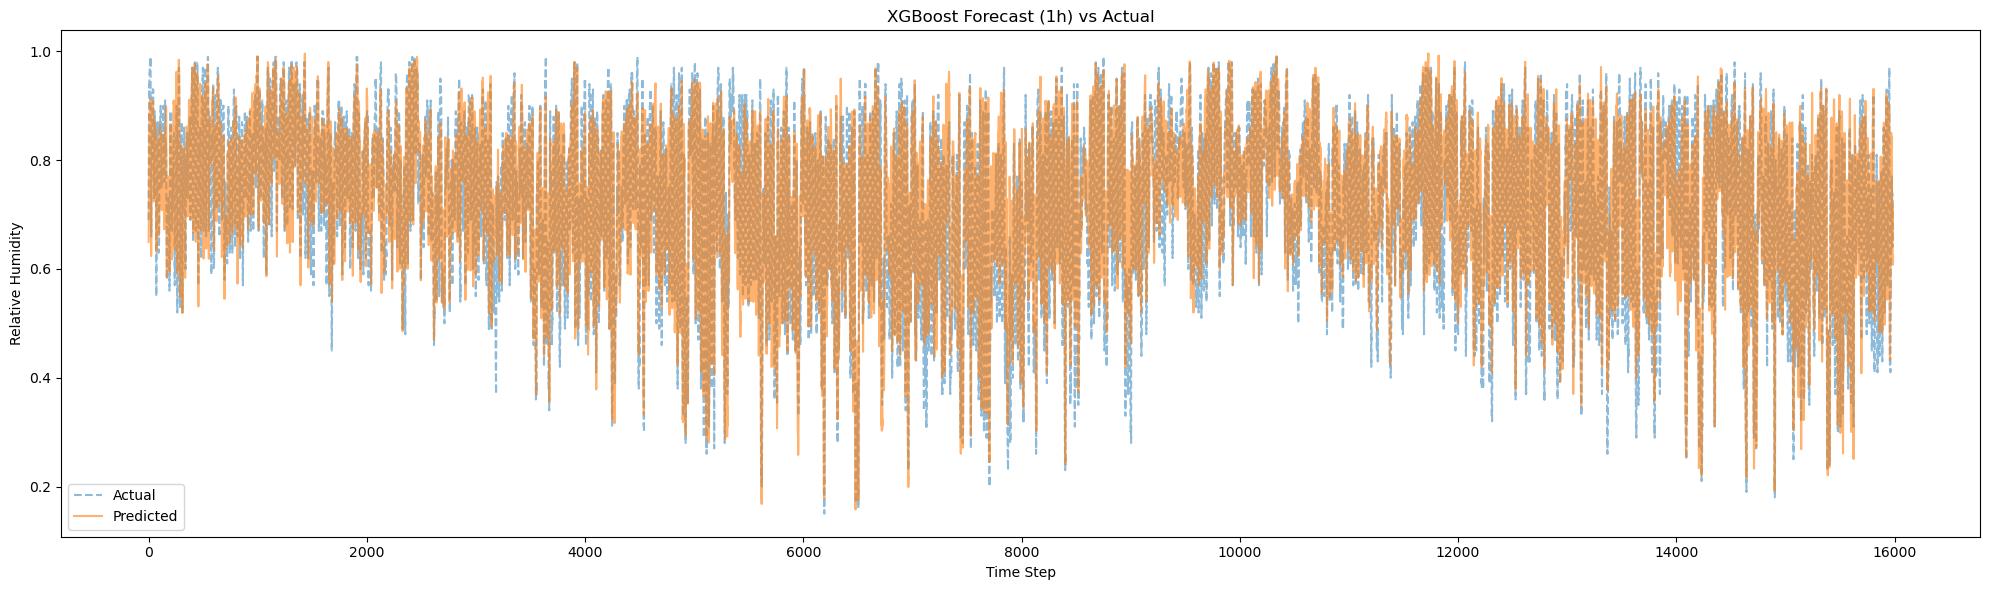

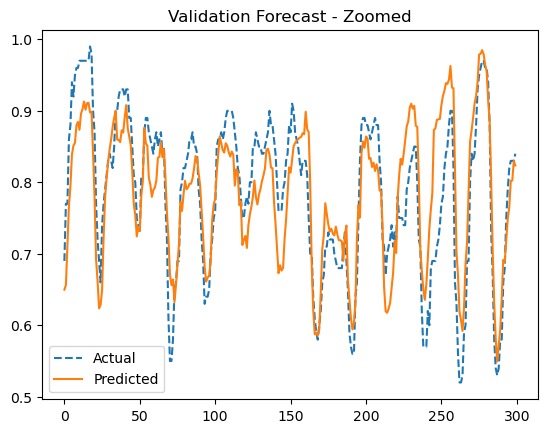


📌 Running XGBoost for 6h forecast (lag_N = 72)
✅ R2: 0.7043 | MAE: 0.0657 | MSE: 0.0078


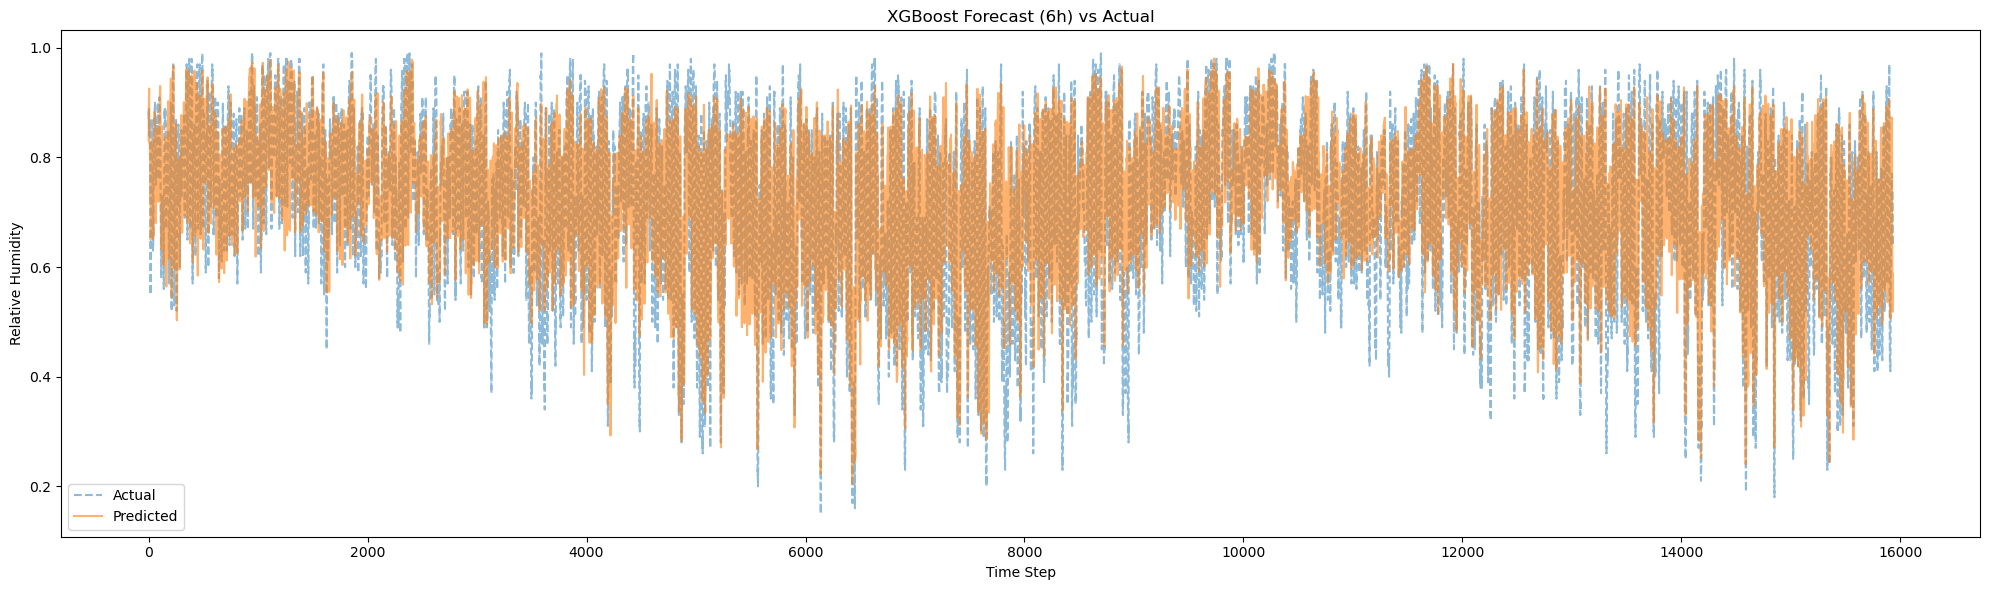

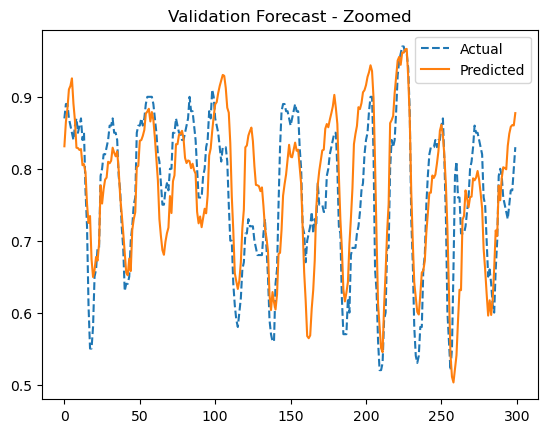


📌 Running XGBoost for 24h forecast (lag_N = 24)
✅ R2: 0.5204 | MAE: 0.0839 | MSE: 0.0126


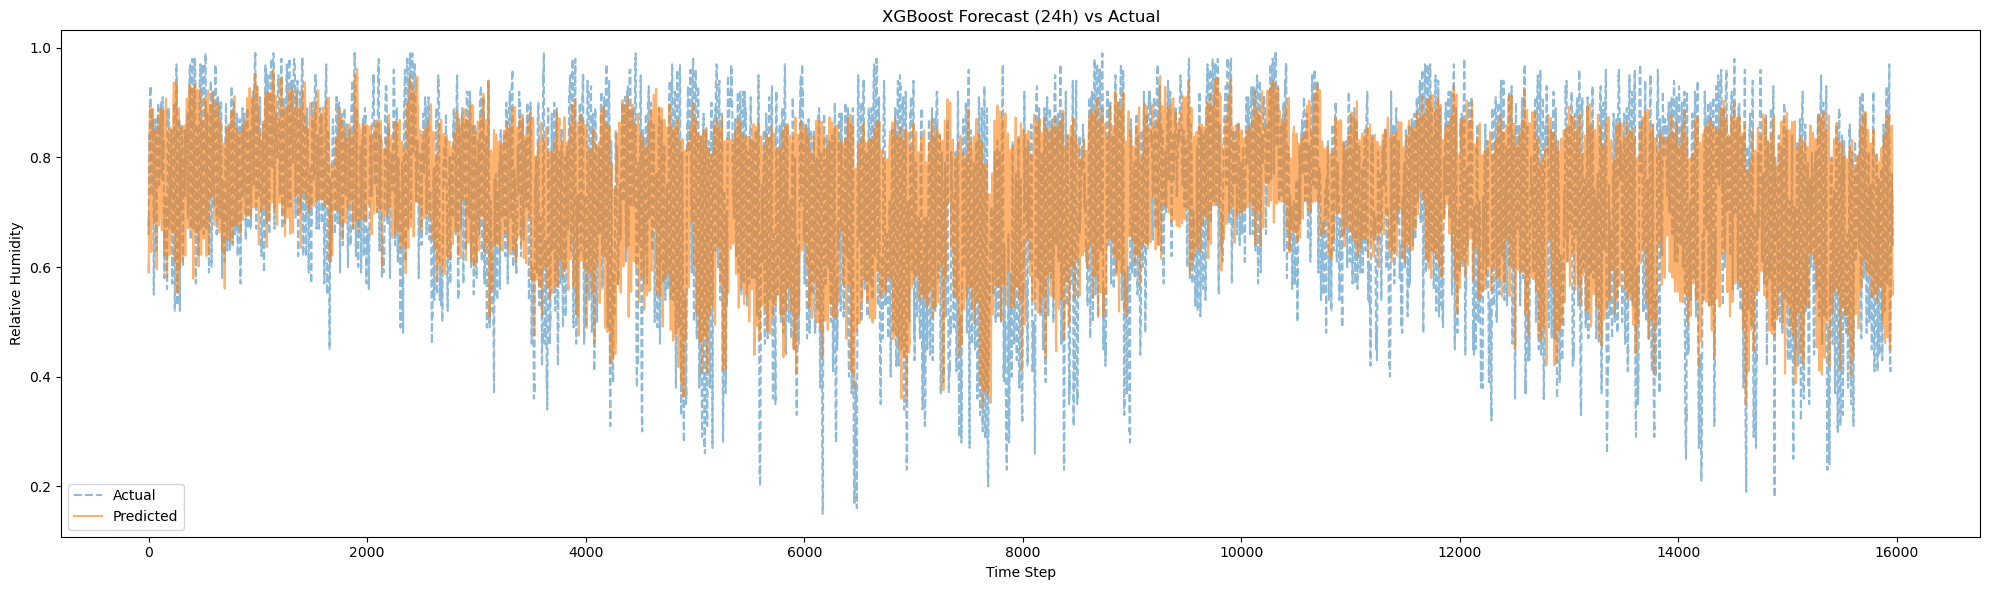

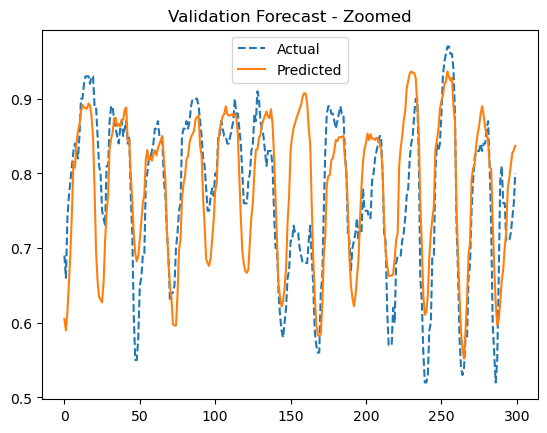

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

best_params = {'1h': {'n_estimators': 402, 'max_depth': 4, 'learning_rate': 0.1111296522712185, 'subsample': 0.9258719487999938, 'colsample_bytree': 0.7124578410314139, 'min_child_weight': 5, 'gamma': 3.417676377794894, "objective": "reg:absoluteerror"}, '6h': {'n_estimators': 461, 'max_depth': 8, 'learning_rate': 0.041149394705246665, 'subsample': 0.8705932706879076, 'colsample_bytree': 0.8805423509397216, 'min_child_weight': 2, 'gamma': 0.013941209847180835, "objective": "reg:absoluteerror",}, '24h': {'n_estimators': 387, 'max_depth': 7, 'learning_rate': 0.014221824435010709, 'subsample': 0.8228585310083995, 'colsample_bytree': 0.7188464233500668, 'min_child_weight': 6, 'gamma': 3.427659441604235, "objective": "reg:absoluteerror",}}


# Loop over forecast horizons
for label, config in forecast_configs.items():
    print(f"\n📌 Running XGBoost for {label} forecast (lag_N = {config['lag_N']})")

    horizon = config["horizon"]
    lag_N = config["lag_N"]
    params = best_params[label]

    train_lagged = create_lagged_data(df_train, lag_N, horizon, available_features)
    val_lagged = create_lagged_data(df_val, lag_N, horizon, available_features)

    # Use only lagged features
    X_train = train_lagged[[col for col in train_lagged.columns if "lag" in col]]
    y_train = train_lagged[target]
    X_val = val_lagged[[col for col in val_lagged.columns if "lag" in col]]
    y_val = val_lagged[target]

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    mae = mean_absolute_error(y_val, preds)
    mse = mean_squared_error(y_val, preds)
    r2 = r2_score(y_val, preds)

    print(f"✅ R2: {r2:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f}")

    # === Predicted vs Actual ===
    plt.figure(figsize=(20, 6))
    plt.plot(y_val.reset_index(drop=True), label='Actual', linestyle='--', alpha=0.5)
    plt.plot(preds, label='Predicted', alpha=0.6)
    plt.title(f"XGBoost Forecast ({label}) vs Actual")
    plt.xlabel("Time Step")
    plt.ylabel("Relative Humidity")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.plot(y_val[:300], label="Actual", linestyle='--')
    plt.plot(preds[:300], label="Predicted")
    plt.legend()
    plt.title("Validation Forecast - Zoomed")
    plt.show()



## Feature importances and Pruning

- Feature importances were extracted using the built-in feature_importances_ attribute from XGBoost.
- For each forecast horizon model, we kept features that was required to explain 95% of the variance.
- The pruned model was retrained using the remaining features, and its performance was evaluated on the same validation set.

## Results
- In all three forecast horizons, pruning low-importance features did not improve performance.
- MAE increased and R² dropped slightly or significantly across all models.
- This suggests that even features with low standalone importance may contribute useful signal when combined with others — especially in time series contexts where temporal redundancy (like lagged inputs) matters

In [30]:
# Best Optuna parameters from earlier
best_params = {'1h': {'n_estimators': 402, 'max_depth': 4, 'learning_rate': 0.1111296522712185, 'subsample': 0.9258719487999938, 'colsample_bytree': 0.7124578410314139, 'min_child_weight': 5, 'gamma': 3.417676377794894, "objective": "reg:absoluteerror"}, '6h': {'n_estimators': 461, 'max_depth': 8, 'learning_rate': 0.041149394705246665, 'subsample': 0.8705932706879076, 'colsample_bytree': 0.8805423509397216, 'min_child_weight': 2, 'gamma': 0.013941209847180835, "objective": "reg:absoluteerror",}, '24h': {'n_estimators': 387, 'max_depth': 7, 'learning_rate': 0.014221824435010709, 'subsample': 0.8228585310083995, 'colsample_bytree': 0.7188464233500668, 'min_child_weight': 6, 'gamma': 3.427659441604235, "objective": "reg:absoluteerror",}}

# Main loop for each forecast horizon
for label, config in forecast_configs.items():
    print(f"\n🔁 {label} forecast: Feature pruning evaluation")

    horizon = config["horizon"]
    lag_N = config["lag_N"]
    params = best_params[label]

    # Create lagged datasets
    train_lagged = create_lagged_data(df_train, lag_N, horizon, available_features)
    val_lagged = create_lagged_data(df_val, lag_N, horizon, available_features)

    X_train = train_lagged[[col for col in train_lagged.columns if "lag" in col]]
    y_train = train_lagged[target]
    X_val = val_lagged[[col for col in val_lagged.columns if "lag" in col]]
    y_val = val_lagged[target]

    # === Train original model ===
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    mae_full = mean_absolute_error(y_val, preds)
    r2_full = r2_score(y_val, preds)
    print(f"📊 Full model → MAE: {mae_full:.4f} | R²: {r2_full:.4f}")

    # === Get feature importances and sort them ===
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        "feature": X_train.columns,
        "importance": importances
    }).sort_values(by="importance", ascending=False).reset_index(drop=True)

    # === Calculate cumulative importance ===
    importance_df["cumulative"] = importance_df["importance"].cumsum()

    # === Find threshold to retain 95% importance ===
    cutoff_index = importance_df[importance_df["cumulative"] >= 0.95].index[0]
    threshold = importance_df.loc[cutoff_index, "importance"]

    # === Select top features that reach 95% of importance ===
    selected_features = importance_df[importance_df["importance"] >= threshold]["feature"].tolist()

    # === Retrain with pruned features ===
    X_train_pruned = X_train[selected_features]
    X_val_pruned = X_val[selected_features]

    model_pruned = XGBRegressor(**params)
    model_pruned.fit(X_train_pruned, y_train)
    preds_pruned = model_pruned.predict(X_val_pruned)

    mae_pruned = mean_absolute_error(y_val, preds_pruned)
    r2_pruned = r2_score(y_val, preds_pruned)

    print(f"✂️ Pruned model → MAE: {mae_pruned:.4f} | R²: {r2_pruned:.4f}")
    print(f"📉 Dropped {len(X_train.columns) - len(selected_features)} features to reach 95% importance")



🔁 1h forecast: Feature pruning evaluation
📊 Full model → MAE: 0.0500 | R²: 0.8365
✂️ Pruned model → MAE: 0.0502 | R²: 0.8357
📉 Dropped 91 features to reach 95% importance

🔁 6h forecast: Feature pruning evaluation
📊 Full model → MAE: 0.0657 | R²: 0.7043
✂️ Pruned model → MAE: 0.0658 | R²: 0.7028
📉 Dropped 247 features to reach 95% importance

🔁 24h forecast: Feature pruning evaluation
📊 Full model → MAE: 0.0839 | R²: 0.5204
✂️ Pruned model → MAE: 0.0840 | R²: 0.5192
📉 Dropped 72 features to reach 95% importance


# Final testing on held back 20% dataset



📌 Running XGBoost for 1h forecast (lag_N = 24)
✅ R2: 0.8387 | MAE: 0.0489 | MSE: 0.0040


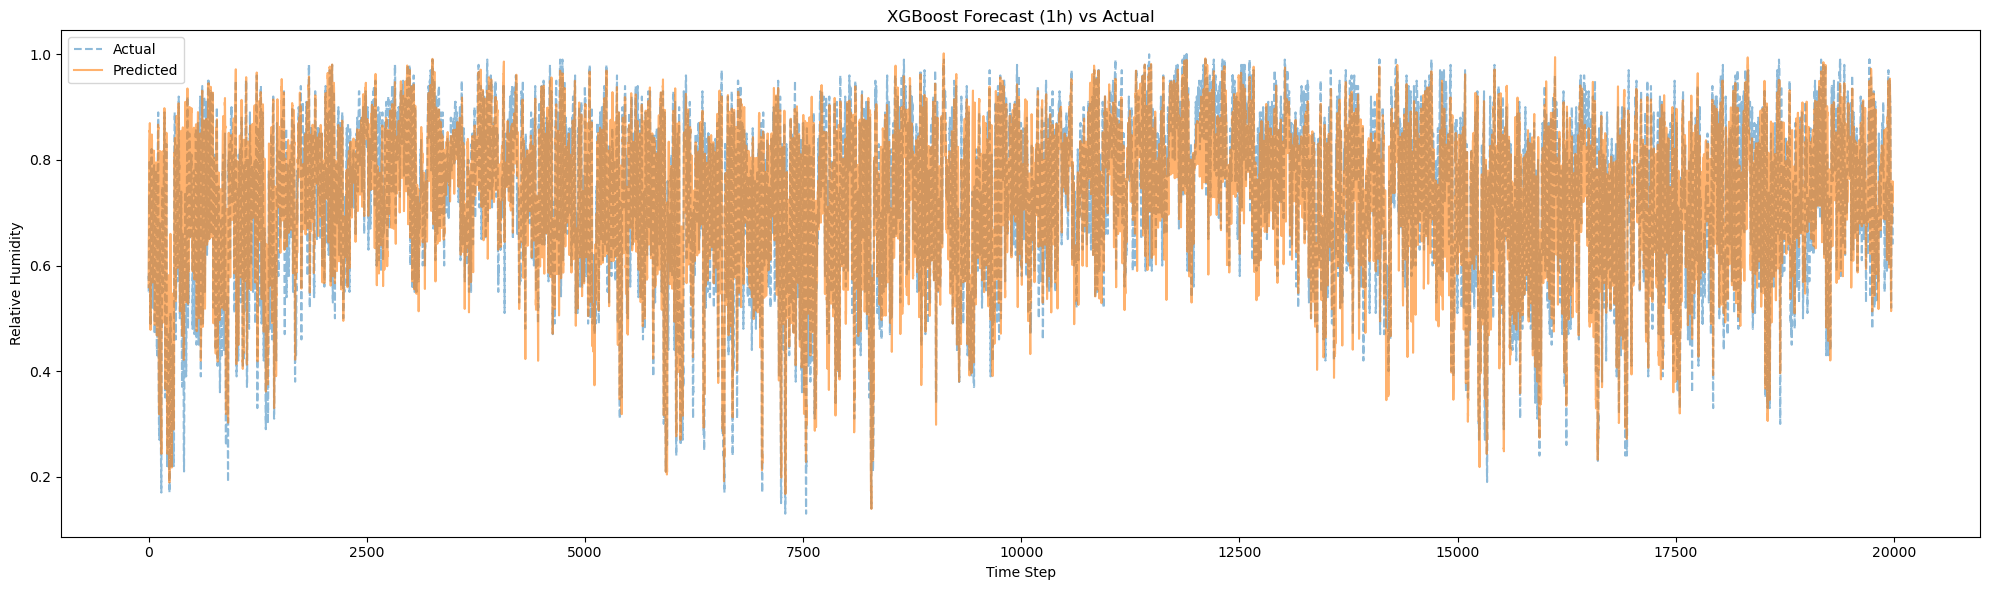


📌 Running XGBoost for 6h forecast (lag_N = 72)
✅ R2: 0.7023 | MAE: 0.0644 | MSE: 0.0073


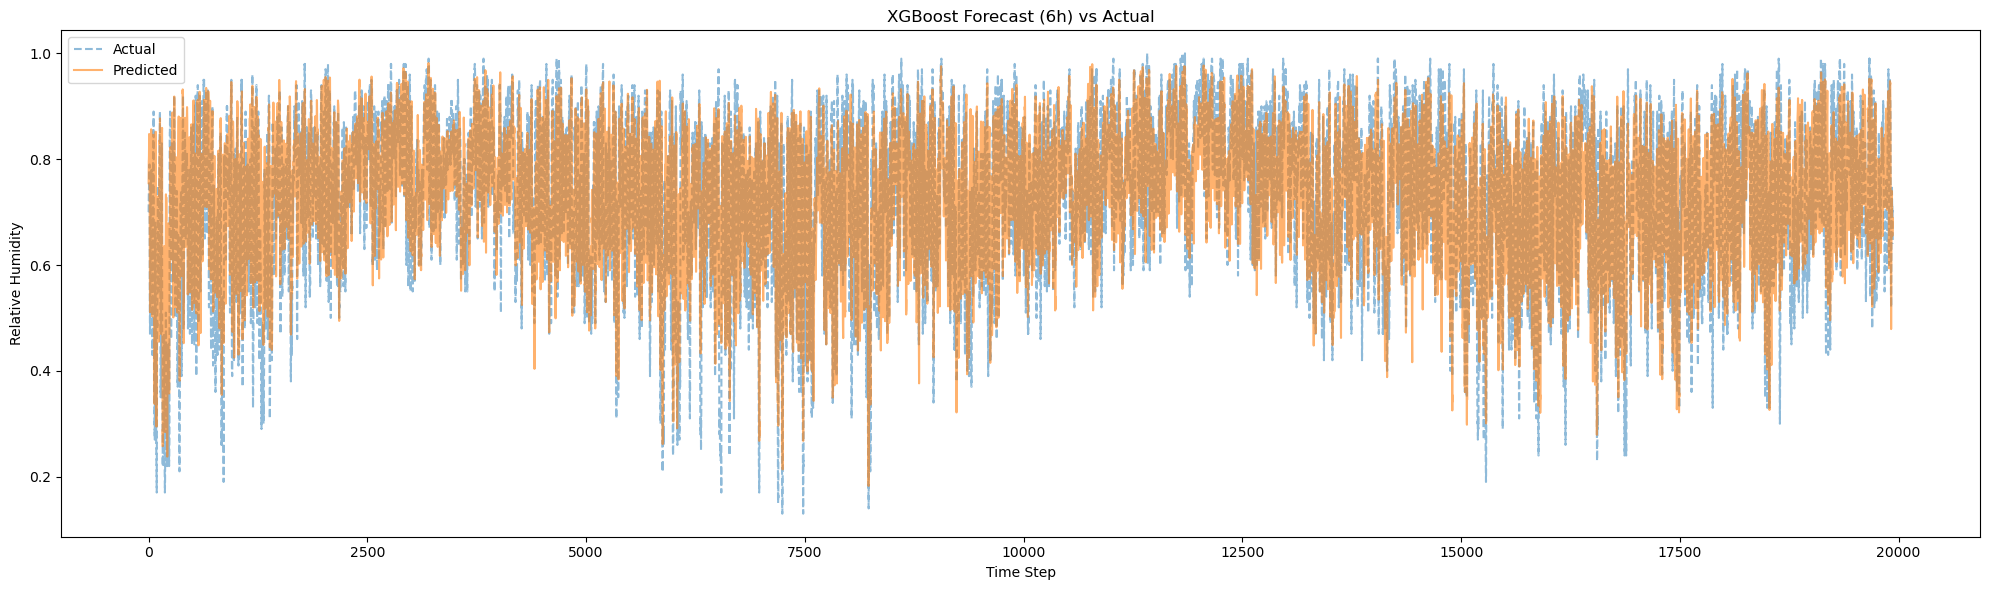


📌 Running XGBoost for 24h forecast (lag_N = 24)
✅ R2: 0.5280 | MAE: 0.0808 | MSE: 0.0116


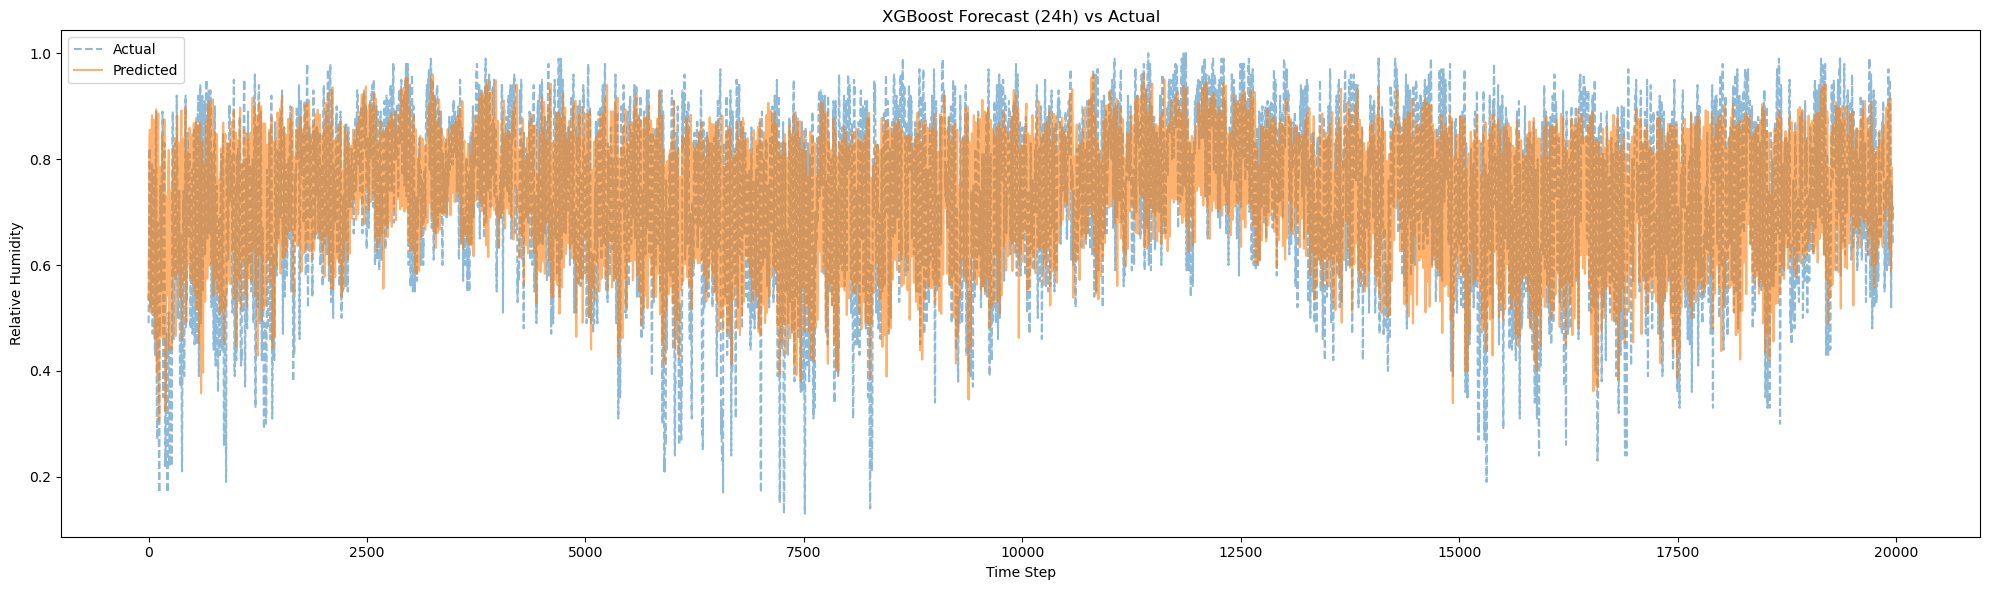

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# === Best parameters from Optuna for each forecast horizon ===
best_params = {'1h': {'n_estimators': 402, 'max_depth': 4, 'learning_rate': 0.1111296522712185, 'subsample': 0.9258719487999938, 'colsample_bytree': 0.7124578410314139, 'min_child_weight': 5, 'gamma': 3.417676377794894, "objective": "reg:absoluteerror"}, '6h': {'n_estimators': 461, 'max_depth': 8, 'learning_rate': 0.041149394705246665, 'subsample': 0.8705932706879076, 'colsample_bytree': 0.8805423509397216, 'min_child_weight': 2, 'gamma': 0.013941209847180835, "objective": "reg:absoluteerror",}, '24h': {'n_estimators': 387, 'max_depth': 7, 'learning_rate': 0.014221824435010709, 'subsample': 0.8228585310083995, 'colsample_bytree': 0.7188464233500668, 'min_child_weight': 6, 'gamma': 3.427659441604235, "objective": "reg:absoluteerror",}}


# Loop over forecast horizons
for label, config in forecast_configs.items():
    print(f"\n📌 Running XGBoost for {label} forecast (lag_N = {config['lag_N']})")

    horizon = config["horizon"]
    lag_N = config["lag_N"]
    params = best_params[label]

    train_lagged = create_lagged_data(df_trainval, lag_N, horizon, available_features)
    val_lagged = create_lagged_data(df_test, lag_N, horizon, available_features)

    # Use only lagged features
    X_train = train_lagged[[col for col in train_lagged.columns if "lag" in col]]
    y_train = train_lagged[target]
    X_val = val_lagged[[col for col in val_lagged.columns if "lag" in col]]
    y_val = val_lagged[target]

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    mae = mean_absolute_error(y_val, preds)
    mse = mean_squared_error(y_val, preds)
    r2 = r2_score(y_val, preds)

    print(f"✅ R2: {r2:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f}")

    # === Predicted vs Actual ===
    plt.figure(figsize=(20, 6))
    plt.plot(y_val.reset_index(drop=True), label='Actual', linestyle='--', alpha=0.5)
    plt.plot(preds, label='Predicted', alpha=0.6)
    plt.title(f"XGBoost Forecast ({label}) vs Actual")
    plt.xlabel("Time Step")
    plt.ylabel("Relative Humidity")
    plt.legend()
    plt.tight_layout()
    plt.show()


